
**필요한 툴 불러오기**

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns

In [ ]:
!pip install openpyxl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 1.7 MB/s eta 0:00:00


**데이터 불러오기**

In [ ]:
df = pd.read_excel('online_retail_II.xlsx',sheet_name=None)

In [ ]:
df = pd.concat(df, ignore_index=True)  #시트가 두개라 합쳐줌
df = df.drop_duplicates() #2010-12-01 ~ 2010-12-09 값이 두 시트에 모두 존재하여 중복을 제거함

In [ ]:
df = df.dropna(subset=['Customer ID'], how='any', axis=0)

In [ ]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
# 데이터 타입 변환
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Customer ID를 정수형으로 변환 (NaN 값이 있는 경우 제거)
df = df.dropna(subset=['Customer ID'])

# 총 구매 금액 계산
df['TotalAmount'] = df['Quantity'] * df['Price']

# 데이터 확인
# print(df.head())
# print(df.info())


In [ ]:
fixed = pd.to_datetime('2024-07-15') #기준날짜
df['Duration'] = (fixed - df['InvoiceDate']).dt.days  #기준날짜 기준으로 마지막 소비가 얼마나 지났는가

This dataset contains non-store online retail records.
The duration of the data is as follows. It almost for 2 years.
In the dataset, We have 797,885 observations and 8 variables.
The Data type is Numerical and Categorical.

There are some variables that we want to focus on such as Invoice, Invoice Date, Quantity, Price.
Invoice means Unique transaction Identifier
Invoice date means Transaction Date
Quantity means the number of products purchased by the customer
Price means price per Unit of the Product.

**데이터 시각화**

In [ ]:
description1 = df.groupby('Description').agg({'Quantity':'sum'})
sorteddes = description1.sort_values('Quantity',ascending=False)
sorteddes = sorteddes.head(20)
sorteddes.reset_index(inplace=True)

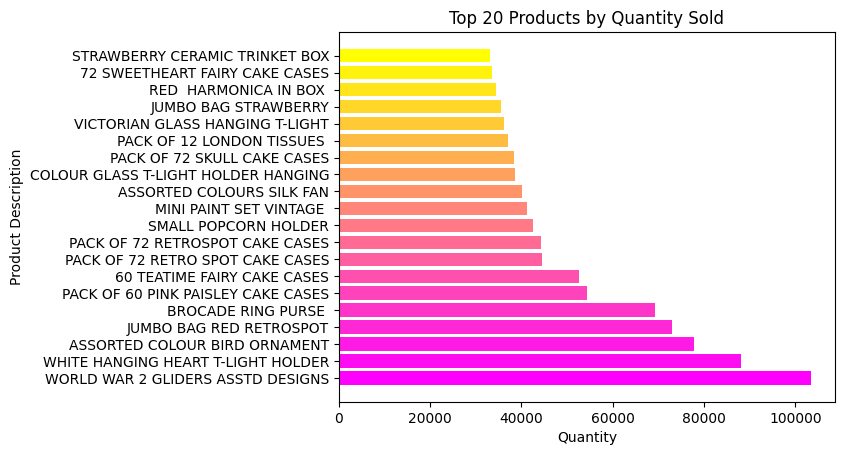

In [ ]:
colors = plt.cm.spring(np.linspace(0, 1, len(sorteddes)))
plt.xlabel('Quantity')
plt.ylabel('Product Description')
plt.title('Top 20 Products by Quantity Sold')

plt.barh(sorteddes['Description'], sorteddes['Quantity'],color=colors)
plt.show()

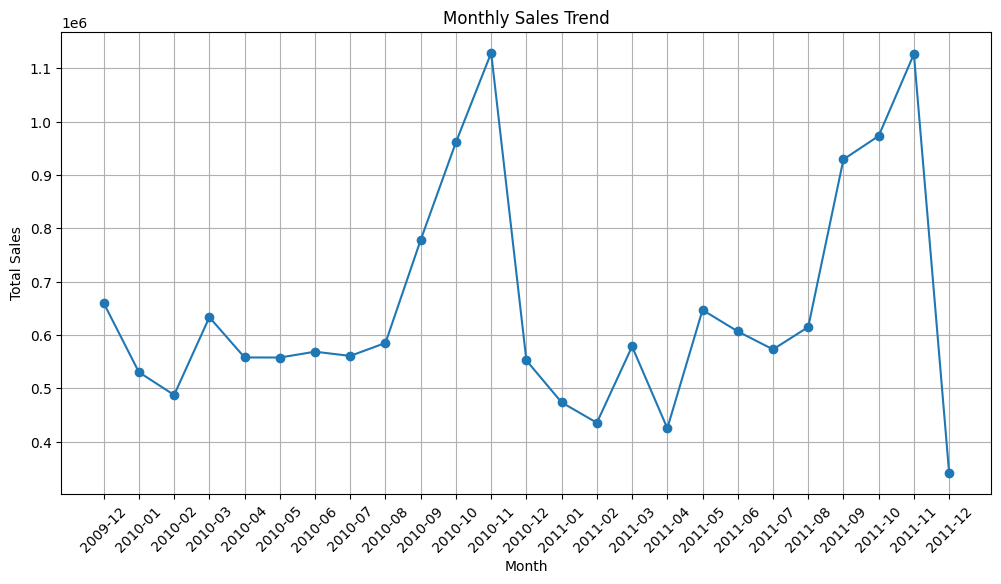

In [ ]:
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month').agg({'TotalAmount': 'sum'}).reset_index()

plt.figure(figsize=(12, 6))
plt.plot(monthly_sales['Month'].astype(str), monthly_sales['TotalAmount'], marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


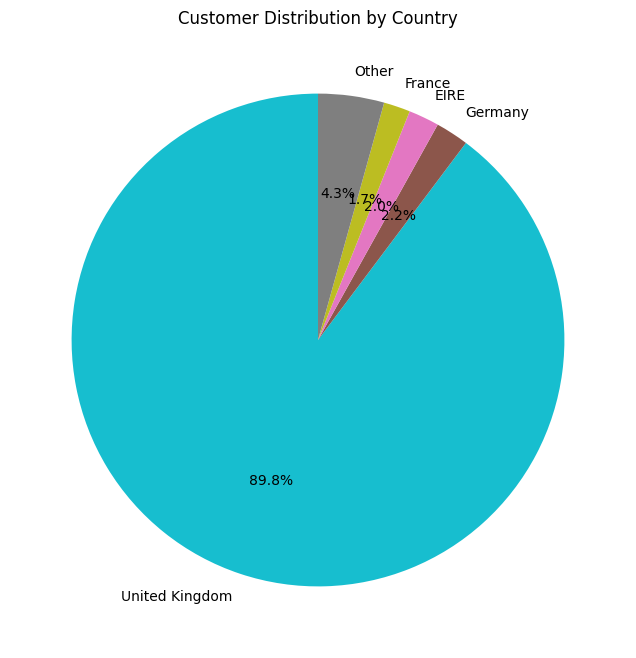

In [ ]:
a=df.pivot_table(index=['Country'],values='Customer ID' , aggfunc='count').reset_index().sort_values('Customer ID',ascending=False)

# 상위 4개 국가 및 나머지를 "기타"로 합침
top_n = 4
top_countries = a[:top_n]
other_countries = a[top_n:]
other_sum = other_countries['Customer ID'].sum()

# "기타" 행을 데이터프레임으로 만듦
other_row = pd.DataFrame({'Country': ['Other'], 'Customer ID': [other_sum]})

# 상위 4개 국가 데이터프레임에 "기타" 추가
top_countries = pd.concat([top_countries, other_row], ignore_index=True)

colors=[ '#17becf', '#8c564b', '#e377c2', '#bcbd22','#7f7f7f']

# 원 그래프 그리기
plt.figure(figsize=(8, 8))
plt.pie(top_countries['Customer ID'], labels=top_countries['Country'], autopct='%1.1f%%', startangle=90, colors=colors)
plt.title('Customer Distribution by Country')
plt.show()

**RFM 분석**

In [ ]:
df2= df.groupby('Customer ID').agg({'Invoice' : 'nunique',
                               'TotalAmount':'sum',
                               'Duration':'min'})
df2

,Invoice,TotalAmount,Duration
Customer ID,,,
12346.0,17,-51.74,4926
12347.0,8,4921.53,4603
12348.0,5,2019.40,4676
12349.0,5,4404.54,4619
12350.0,1,334.40,4911
...,...,...,...
18283.0,22,2664.90,4604
18284.0,2,436.68,5030
18285.0,1,427.00,5261


              Invoice  TotalAmount  Duration
Invoice      1.000000     0.614836 -0.257170
TotalAmount  0.614836     1.000000 -0.130403
Duration    -0.257170    -0.130403  1.000000


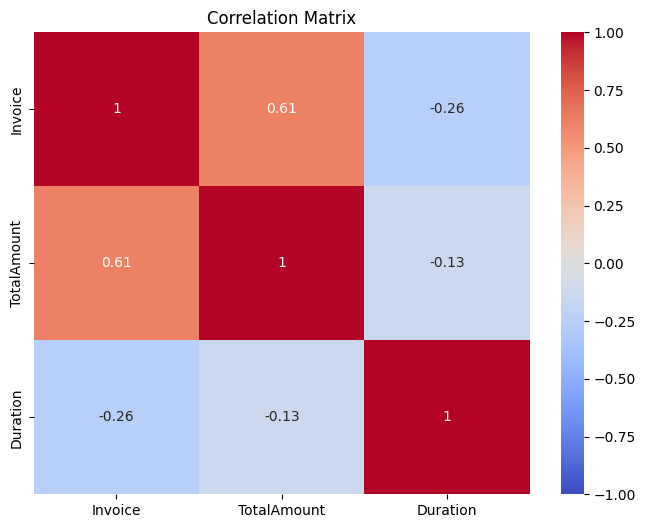

In [ ]:
# 상관관계 계산
correlation_matrix = df2.corr()

# 상관관계 행렬 출력
print(correlation_matrix)

# 상관관계 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Through this correlation matrix, we found out that there is Correlation between [Invoice] and [TotalAmount} for 61 percent.
It means that [Invoice] and [TotalAmount] have a fairly significant relationship, indicating that when one variable increases, the other variable tends to increase as well.

** 아래 2개의 그래프 고객 ID 겹치는 부분 체크하기

In [ ]:
df2.reset_index(inplace=True)

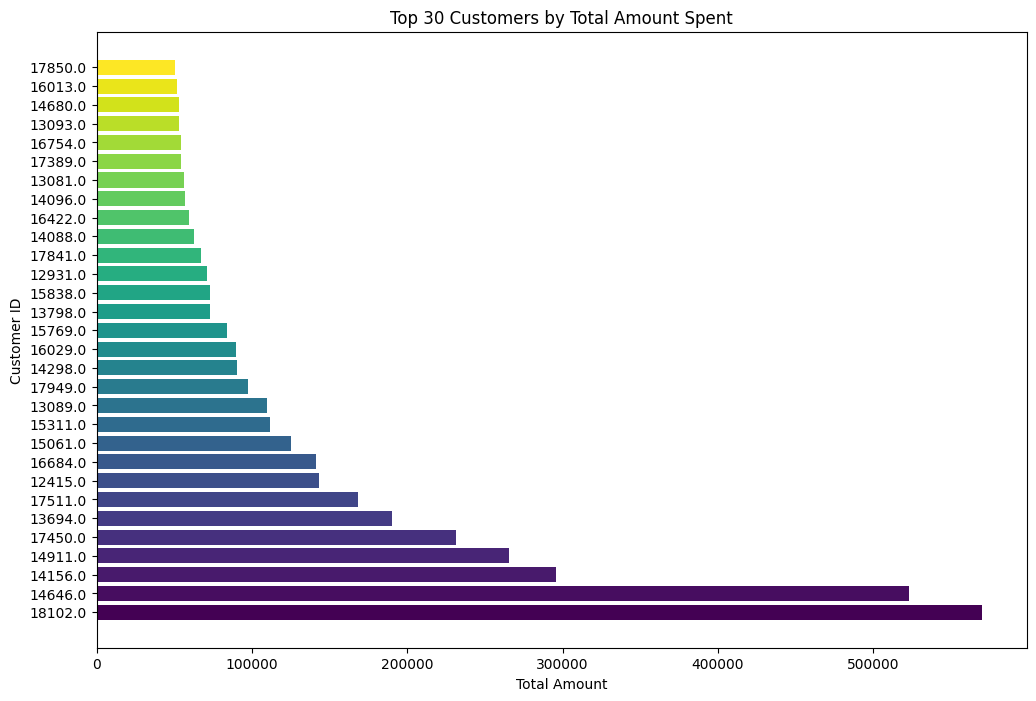

In [ ]:
total1 = df2.sort_values('TotalAmount', ascending=False).head(30)
colors = plt.cm.viridis(np.linspace(0, 1, len(total1)))
total1['Customer ID'] = total1['Customer ID'].astype(str)

plt.figure(figsize=(12, 8))
plt.barh(total1['Customer ID'], total1['TotalAmount'], color=colors)
plt.xlabel('Total Amount')
plt.ylabel('Customer ID')
plt.title('Top 30 Customers by Total Amount Spent')
plt.show()


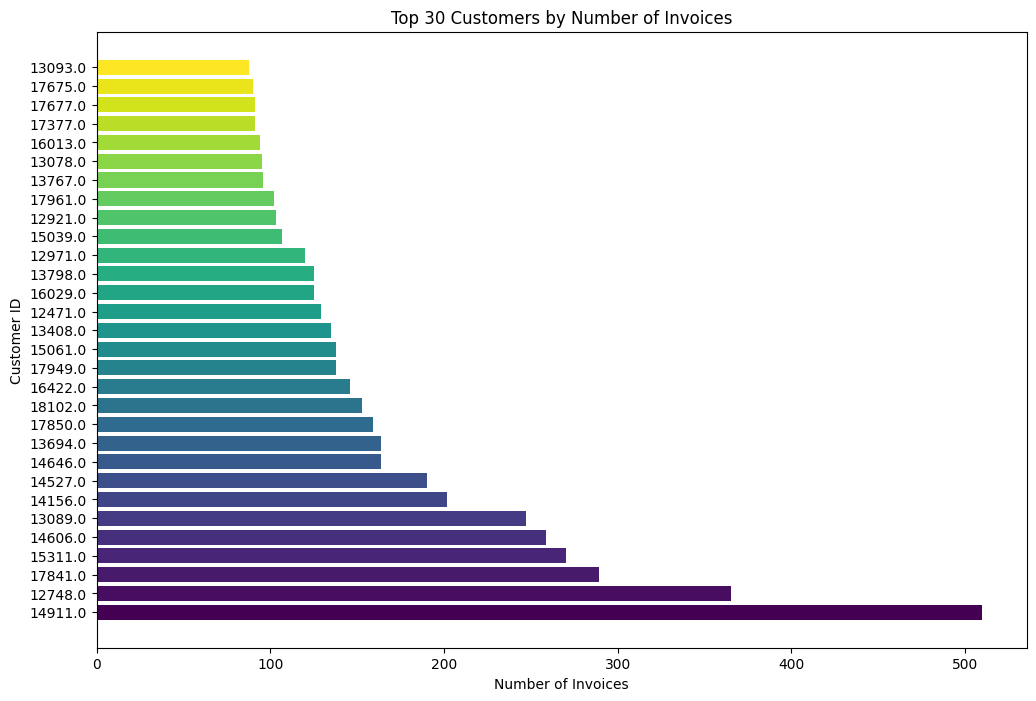

In [ ]:
invoice1 = df2.sort_values('Invoice', ascending=False).head(30)
colors = plt.cm.viridis(np.linspace(0, 1, len(invoice1)))
invoice1['Customer ID'] = invoice1['Customer ID'].astype(str)

plt.figure(figsize=(12, 8))
plt.barh(invoice1['Customer ID'], invoice1['Invoice'], color=colors)
plt.xlabel('Number of Invoices')
plt.ylabel('Customer ID')
plt.title('Top 30 Customers by Number of Invoices')
plt.show()


**RFM 분석 기반 clustering**

We used the RFM analysis method to analyze the characteristics of customers who purchased online retail. In addition, based on the RFM analysis, we tried to cluster customers using the k-means.

RFM is the analysis method of customer characteristics using frequency, frequency, and monitoring. R means How recently a customer made a purchase. We obtained the recency through The Most Recent Duration of Each Customer's Transactions . F means How often a customer makes a purchase. We used ‘invoice’ column for this. M means How much money a customer spends on purchases. TotalAmount column was used for this.

In [ ]:
data = df2[['Invoice', 'TotalAmount', 'Duration']].values

In [ ]:
labels = df2['Customer ID'].values

In [ ]:
mms = MinMaxScaler()
mms.fit(data)
data_transformed = mms.transform(data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

<function matplotlib.pyplot.show(close=None, block=None)>

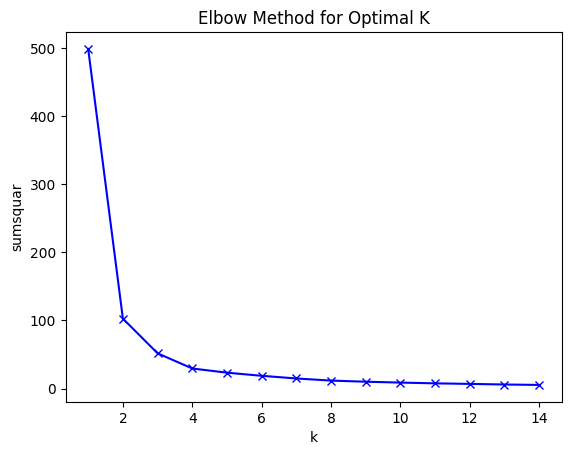

In [ ]:
sumsquar = []
# Set the optimal K
K = range(1,15) #Loading library
for k in K:
  km = KMeans(n_clusters=k)
  km = km.fit(data_transformed)
  sumsquar.append(km.inertia_)

plt.plot(K,sumsquar,'bx-')
plt.xlabel('k')
plt.ylabel('sumsquar')
plt.title('Elbow Method for Optimal K')
plt.show


For clustering, we used K-means model. To choose the optimal number of clusters ,K, we used the Elbow Method. By plotting the sum of squared distances for K values from 1 to 15, we identified the 'elbow' point at K=4.

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(data_transformed)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4)

**각 cluster 특성 분석**

In [ ]:
clusters = kmeans.labels_

In [ ]:
df2['cluster']=clusters

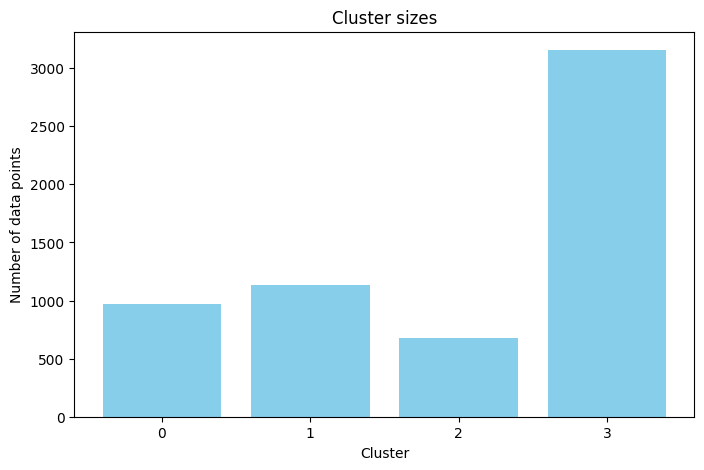

In [ ]:
clustersize = df2['cluster'].value_counts().sort_index()

plt.figure(figsize=(8,5))
plt.bar(clustersize.index,clustersize.values,color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Number of data points')
plt.title('Cluster sizes')
plt.xticks(clustersize.index)
plt.show()

In [ ]:
df3 = df2.groupby('cluster').agg({'Invoice': 'mean',
                                  'TotalAmount': 'mean',
                                  'Duration': 'mean'}).reset_index()

df3['cluster'] = df3['cluster'].astype(str)

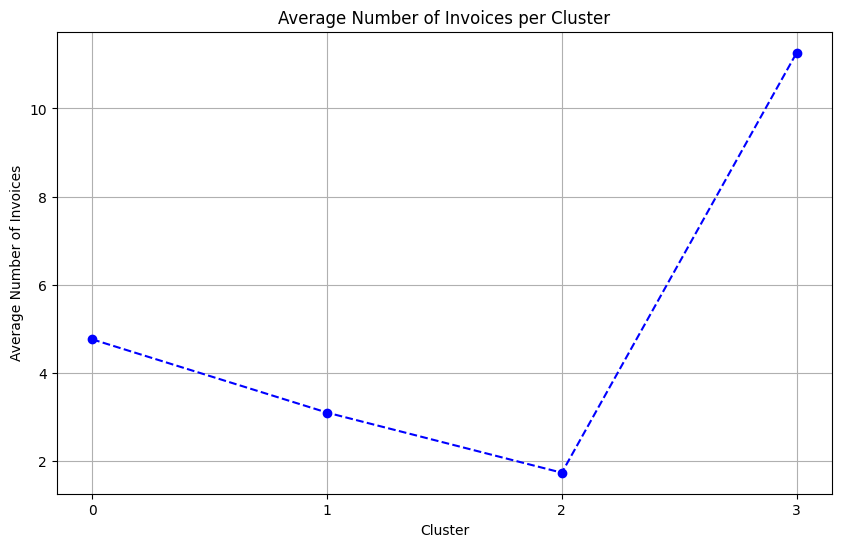

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df3['cluster'], df3['Invoice'], 'bo--')
plt.xlabel('Cluster')
plt.ylabel('Average Number of Invoices')
plt.title('Average Number of Invoices per Cluster')
plt.grid(True)



plt.show()


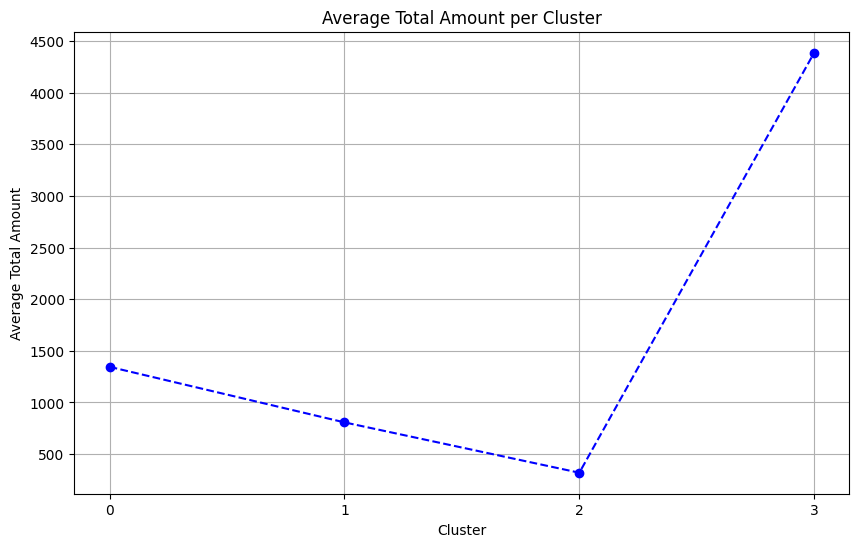

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df3['cluster'], df3['TotalAmount'], 'bo--')
plt.xlabel('Cluster')
plt.ylabel('Average Total Amount')
plt.title('Average Total Amount per Cluster')
plt.grid(True)
plt.show()


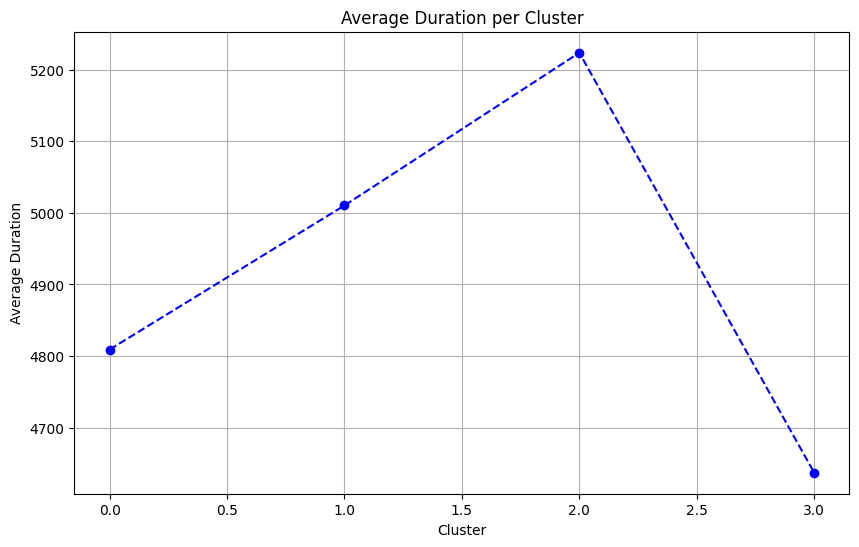

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(df3['cluster'], df3['Duration'], 'bo--')
plt.xlabel('Cluster')
plt.ylabel('Average Duration')
plt.title('Average Duration per Cluster')
plt.grid(True)
plt.show()


In [ ]:
z=df2.TotalAmount.quantile(0.05) #이상치 필터링
y=df2.TotalAmount.quantile(0.7)
iqr=y-z

In [ ]:
df2 = df2[(df2['TotalAmount']>=z-1.5*iqr)&(df2['TotalAmount']<=y+1.5*iqr)]

In [ ]:
z=df2.Duration.quantile(0.05)
y=df2.Duration.quantile(0.8)
iqr=y-z

In [ ]:
df2 = df2[(df2['Duration']>=z-1.5*iqr)&(df2['Duration']<=y+1.5*iqr)]

In [ ]:
z=df2.Invoice.quantile(0.05)
y=df2.Invoice.quantile(0.8)
iqr=y-z
df2 = df2[(df2['Invoice']>=z-1.5*iqr)&(df2['Invoice']<=y+1.5*iqr)]

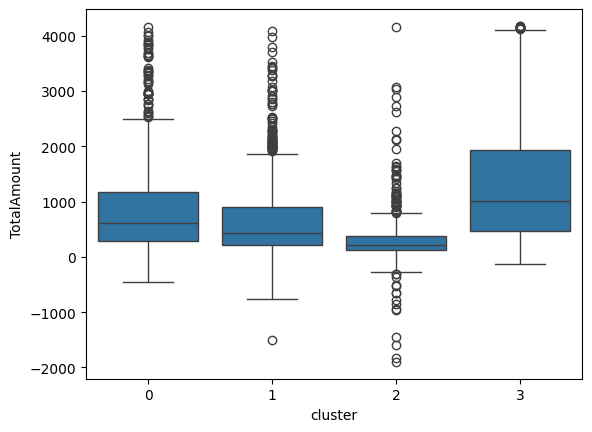

In [ ]:
sns.boxplot(x='cluster',y='TotalAmount',data=df2)
plt.show()

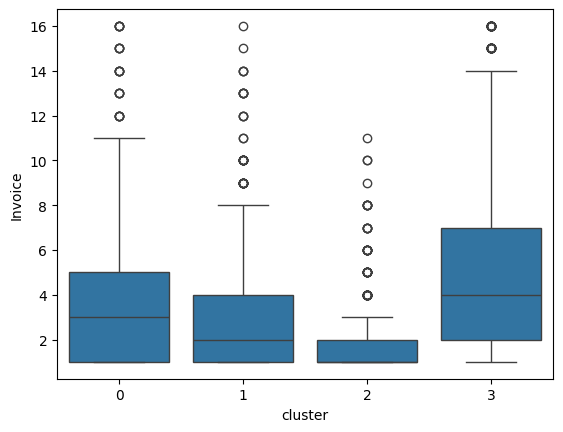

In [ ]:
sns.boxplot(x='cluster',y='Invoice',data=df2)
plt.show()

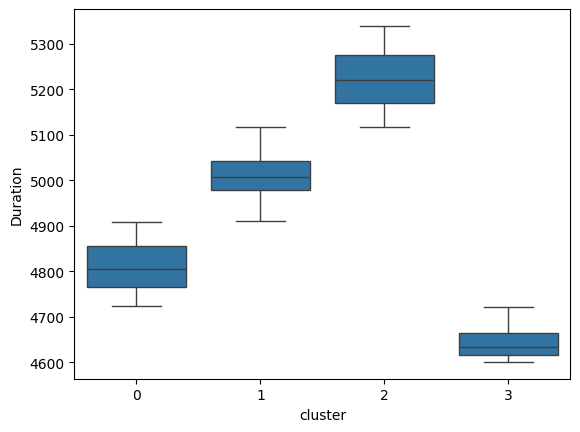

In [ ]:
sns.boxplot(x='cluster',y='Duration',data=df2)
plt.show()

In [ ]:
df2

,Customer ID,Invoice,TotalAmount,Duration,cluster
2,12348.0,5,2019.40,4676,3
4,12350.0,1,334.40,4911,1
5,12351.0,1,300.93,4976,1
6,12352.0,13,1889.21,4637,3
7,12353.0,2,406.76,4805,0
...,...,...,...,...,...
5936,18282.0,3,176.60,4608,3
5938,18284.0,2,436.68,5030,1
5939,18285.0,1,427.00,5261,2
5940,18286.0,3,1188.43,5077,1


In [ ]:
df3

,cluster,Invoice,TotalAmount,Duration
0,0,4.761317,1344.939357,4809.162551
1,1,3.098418,806.963191,5010.297012
2,2,1.733728,319.276675,5223.554734
3,3,11.264259,4388.008584,4637.134030


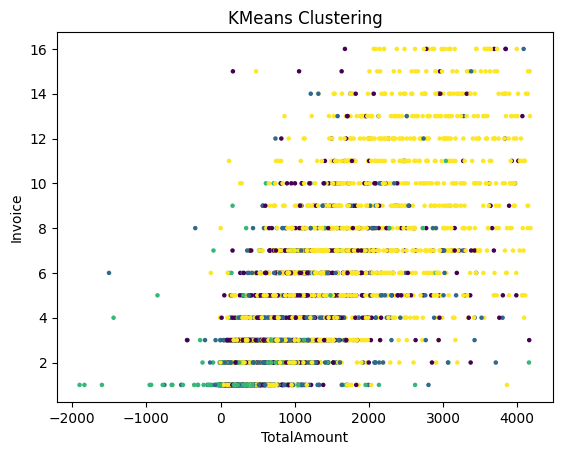

In [ ]:
df2['cluster'] = df2['cluster'].astype(int)

# 결과 시각화 (2D 산점도 예시)
plt.scatter(df2['TotalAmount'], df2['Invoice'], c=df2['cluster'], cmap='viridis', s=5)
plt.xlabel('TotalAmount')
plt.ylabel('Invoice')
plt.title('KMeans Clustering')
plt.show()


In [ ]:
# 3D plot tool 불러오기
from mpl_toolkits.mplot3d import Axes3D

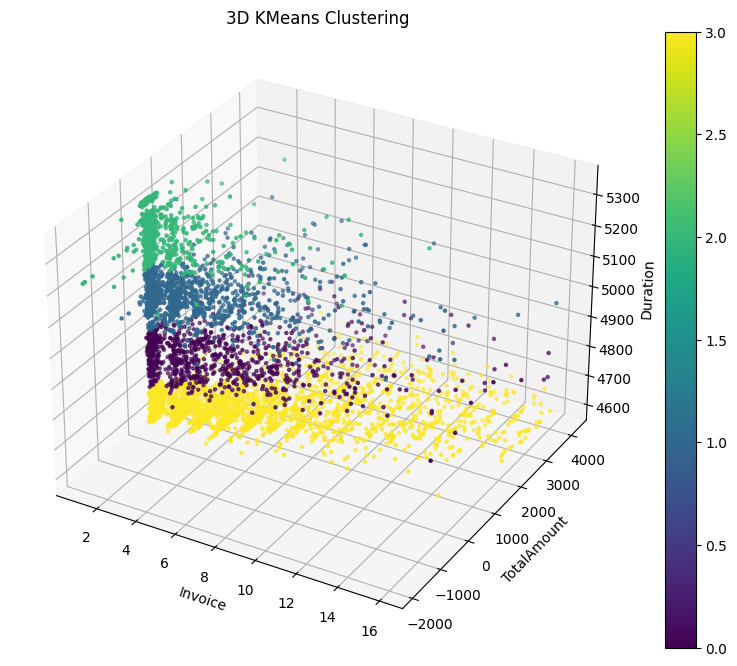

In [ ]:
# Create 3D K-means graph
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df2['Invoice'], df2['TotalAmount'], df2['Duration'], c=df2['cluster'], cmap='viridis', s=5)

# Labeling
ax.set_xlabel('Invoice')
ax.set_ylabel('TotalAmount')
ax.set_zlabel('Duration')
plt.title('3D KMeans Clustering')


plt.colorbar(sc)
plt.show()

For Cluster 1 with high purchase frequency and spending, we will offer a VIP program. For Cluster 2 with moderate purchase frequency and spending, we will provide promotions and discount events. For Cluster 3with low purchase frequency and spending, we will implement retargeting ads. Finally, for Cluster 4with long inactive customers, we will conduct re-engagement campaigns.
